# Together Data Science Agent

Authors: ...

![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)

## Introduction

Welcome to the comprehensive guide for building a ReAct (Reasoning + Acting) Data Science Agent! This notebook demonstrates how to create an intelligent agent that can perform complex data science tasks through iterative reasoning and code execution.

The ReAct framework combines the power of large language models' reasoning capabilities with the practical execution of Python code, creating an agent that can:
- Think through problems step-by-step before taking action
- Execute Python code to perform data analysis, visualization, and machine learning
- Observe results and adapt its approach based on outcomes
- Handle complex, multi-step data science workflows autonomously

##The ReAct Data Science Workflow

<img src="react_flow.png" alt="ReAct Workflow" style="max-width: 400px;">

The above ReAct Data Science Agent offers several key advantages:
1. Iterative Problem Solving: The agent thinks through each step, executes code, observes results, and plans the next action
2. Error Recovery: When code fails or produces unexpected results, the agent can analyze the error and try alternative approaches
3. Adaptive Analysis: The agent can discover patterns in data and adjust its analysis strategy accordingly
Code Generation: Generates and executes Python code for data manipulation, visualization, and machine learning
4. Session Persistence: Maintains state across multiple code executions for complex workflows

Cookbook Contributions
- Set up a complete ReAct agent environment with configurable parameters
- Process complex data science tasks through iterative reasoning and execution
- Generate high-quality analysis results with proper visualizations and insights
- Handle real-world datasets and machine learning workflows

The modular design pattern we showcase makes each component transparent and customizable, allowing you to adapt the system to specific data science domains or analysis styles.

Whether you're a data scientist, researcher, or analyst, this cookbook provides the tools to transform your data science questions into comprehensive, executable analysis workflows.

Let's begin building our intelligent data science assistant!

## Install Packages

In [ ]:
%%capture
!pip install together

In [1]:
#Initialize Necessary Functions and Configuration

import os
import re
import json
import textwrap
import base64
from pathlib import Path
from typing import Dict, Optional, List, Any, Union

from together import Together
from IPython.display import Image, display

## Introduction to ReAct Framework

The ReAct (Reasoning + Acting) framework is a paradigm that combines reasoning and acting in large language models. Unlike traditional approaches that either only reason about problems or only take actions, ReAct interleaves these capabilities to create more effective problem-solving agents.

Core Principles of ReAct
1. Thought: The agent reasons about what to do next, analyzing previous results and planning future actions
2. Action: The agent executes code or uses tools to gather information or perform calculations
3. Observation: The agent observes the results of actions and incorporates them into future reasoning

Why ReAct for Data Science?

Data science workflows are inherently iterative and exploratory. A data scientist typically:
- Examines data to understand its structure
- Tries different approaches based on initial findings
- Iterates on analysis based on intermediate results
- Adapts methodology when encountering unexpected patterns or errors

The ReAct framework naturally mirrors this human data science process, making it ideal for automated data analysis.

## Agent Configuration Parameters

This section defines the key parameters that control the ReAct Data Science Agent behavior. These configuration settings allow you to customize the agent's operation according to your specific needs.

Key Configuration Areas:
- Model Selection: Defines which LLM to use for reasoning and code generation
- Execution Settings: Controls code execution environment and safety
- Iteration Limits: Sets boundaries on how many reasoning cycles to perform
- Output Configuration: Manages result formatting and display options
- Session Management: Configures persistent code execution session handling

Disclaimers ⚠️

This workflow involves multiple LLM calls and code execution, so please be mindful about resource management and costs.

Code Execution Safety: The agent executes Python code using Together Code Interpreter which offers a safe sandboxed environment to run code.

API Requirements: You will need a Together AI API key. Get it [here](https://docs.together.ai/docs/quickstart).

In [5]:
# Raise exception until user reads disclaimers
# raise Exception("Please remove this after reading the disclaimers above ☝️")

# Agent Configuration
# ==================

# Model Selection
# ---------------
reasoning_model = "meta-llama/Llama-3.3-70B-Instruct-Turbo"  # Primary model for reasoning and code generation

# Execution Settings  
# ------------------
max_iterations = 15  # Maximum number of reasoning cycles
temperature = 0.2    # Lower temperature for more consistent code generation
session_timeout = 3600  # Session timeout in seconds

# Display Settings
# ---------------
max_output_length = 500  # Maximum words in displayed output
show_images = True      # Whether to display generated plots
box_width = 80         # Width of output boxes

# Initialize Together Client
# -------------------------
together_client = Together(api_key="your-together-api-key-here")  # Replace with your API key
code_interpreter = together_client.code_interpreter

## Core Components

**Code Execution Engine with Together Code Interpreter**

The heart of our ReAct agent is the code execution capabilities powered with Together Code Interpreter(TCI) that safely runs Python code and processes results.

In [6]:
# This function executes Python code using Together Code Interpreter and returns the result.
def run_python(code: str, session_id: Optional[str] = None, files: Optional[list[Dict[str, str]]] = None):
    """
    Executes Python code using Together Code Interpreter and returns the result.
    Args:
        code: The Python code to execute
        session_id: Optional session ID to maintain state between executions
        files: Optional list of files to upload to the code interpreter
              Each file should be a dict with 'name', 'encoding', and 'content' keys

    Returns:
        The output of the executed code as a JSON
    """
    try:
        kwargs = {"code": code, "language": "python"}

        if session_id:
            kwargs["session_id"] = session_id

        if files:
            kwargs["files"] = files

        response = code_interpreter.run(**kwargs)

        result = {"session_id": response.data.session_id, "status": response.data.status, "outputs": []}

        for output in response.data.outputs:
            result["outputs"].append({"type": output.type, "data": output.data})

        if response.data.errors:
            result["errors"] = response.data.errors

        return result
    except Exception as e:
        error_result = {"status": "error", "error_message": str(e), "session_id": None}
        return error_result

**File Management**

This will later enable the agent to have access to uploaded files located in the `data` repository for workflows that require custom uploaded data.

In [7]:
def collect_files(directory) -> list[Dict[str, str]]:
    """
    Collects all files from the specified directory and its subdirectories.

    Args:
        directory: The directory to scan for files

    Returns:
        A list of file dictionaries ready for upload to the code interpreter
    """
    files = []
    path = Path(directory)

    if not path.exists():
        print(f"Directory '{directory}' does not exist, skipping file collection")
        return files

    for file_path in Path(directory).rglob("*"):
        if file_path.is_file() and not any(part.startswith(".") for part in file_path.parts):
            try:
                # Handle different file types
                if file_path.suffix.lower() in ['.csv', '.txt', '.json', '.py']:
                    with open(file_path, "r", encoding="utf-8") as f:
                        content = f.read()
                    files.append({
                        "name": str(file_path.relative_to(directory)), 
                        "encoding": "string", 
                        "content": content
                    })
                elif file_path.suffix.lower() in ['.xlsx', '.xls']:
                    # For Excel files, we'll let pandas handle them in the code
                    print(f"Excel file detected: {file_path.name} - will be handled by pandas")
                    
            except (UnicodeDecodeError, PermissionError) as e:
                print(f"Could not read file {file_path}: {e}")
                
    return files

**Output Processing and Display**

These functions handle the formatting and display of execution results, including plots and data visualizations.

In [8]:
# Images returned from the code interpreter are base64 encoded and need to be decoded and displayed
def display_image(b64_image):
    """Display base64 encoded images from code execution results"""
    decoded_image = base64.b64decode(b64_image)
    display(Image(data=decoded_image))

# This function creates a comprehensive summary of execution result for the model's history.
def get_execution_summary(execution_result: Dict) -> str:
    """
    Create a comprehensive summary of execution result for the model's history.
    This gives the model better context about what happened during code execution.
    
    Args:
        execution_result: The result dictionary from run_python
        
    Returns:
        A summary of the execution including status, outputs, and any errors
    """
    if not execution_result:
        return "Execution failed - no result returned"
    
    # Check execution status
    status = execution_result.get("status", "unknown")
    summary_parts = [f"Execution status: {status}"]
    
    # Process outputs
    stdout_outputs = []
    display_outputs = []
    other_outputs = []
    
    if "outputs" in execution_result:
        for output in execution_result["outputs"]:
            output_type = output.get("type", "unknown")
            output_data = output.get("data", "")
            
            if output_type == "stdout":
                stdout_outputs.append(output_data)
            elif output_type == "display_data":
                if isinstance(output_data, dict):
                    if "image/png" in output_data:
                        display_outputs.append("Generated plot/image")
                    if "text/plain" in output_data:
                        display_outputs.append(f"Display: {output_data['text/plain']}")
                else:
                    display_outputs.append("Generated display output")
            else:
                other_outputs.append(f"{output_type}: {str(output_data)[:100]}")
    
    # Add stdout outputs
    if stdout_outputs:
        summary_parts.append("Text output:")
        summary_parts.extend(stdout_outputs)
    
    # Add display outputs (plots, images)
    if display_outputs:
        summary_parts.append("Visual outputs:")
        summary_parts.extend(display_outputs)
    
    # Add other outputs
    if other_outputs:
        summary_parts.append("Other outputs:")
        summary_parts.extend(other_outputs)
    
    # Check for errors
    if "errors" in execution_result and execution_result["errors"]:
        summary_parts.append("Errors:")
        summary_parts.extend(execution_result["errors"])
    
    # If no outputs at all but status is success
    if not stdout_outputs and not display_outputs and not other_outputs and status == "success":
        summary_parts.append("Code executed successfully (no explicit output generated)")
    
    return "\n".join(summary_parts)

# This function processes the execution result and extracts text outputs and image data.
def process_execution_result(execution_result: Dict) -> tuple[str, List[str]]:
    """
    Process execution result and extract text outputs and image data.
    
    Args:
        execution_result: The result dictionary from run_python
        
    Returns:
        tuple: (text_output, list_of_image_data)
    """
    text_outputs = []
    image_data = []
    
    if execution_result and "outputs" in execution_result:
        for output in execution_result["outputs"]:
            if output["type"] == "stdout":
                text_outputs.append(output["data"])
            elif output["type"] == "display_data":
                # Handle display data (images, plots, etc.)
                if isinstance(output["data"], dict):
                    if "image/png" in output["data"]:
                        image_data.append(output["data"]["image/png"])
                    # Add text representation if available
                    if "text/plain" in output["data"]:
                        text_outputs.append(f"[Display Data] {output['data']['text/plain']}")
    
    # Join all text outputs
    combined_text = "\n".join(text_outputs) if text_outputs else ""
    
    return combined_text, image_data

**Pretty Printing and Formatting**

These functions create beautiful, readable output boxes for the agent's thoughts and results.

In [9]:
def box_text(text: str, title: Optional[str] = None, emoji: Optional[str] = None) -> str:
    """Create a boxed text with optional title and emoji."""
    # Handle None or empty text
    if not text:
        text = "No output"
    
    # Limit to 500 words for readability
    words = text.split()
    if len(words) > 500:
        words = words[:500]
        words.append("...")
        text = " ".join(words)

    # Wrap text at specified width
    wrapped_lines = []
    for line in text.split("\n"):
        if len(line) > box_width:
            wrapped_lines.extend(textwrap.wrap(line, width=box_width))
        else:
            wrapped_lines.append(line)

    # Handle empty wrapped_lines
    if not wrapped_lines:
        wrapped_lines = ["No output"]

    width = max(len(line) for line in wrapped_lines)
    width = max(width, len(title) if title else 0)

    if title and emoji:
        title = f" {emoji} {title} "
    elif title:
        title = f" {title} "
    elif emoji:
        title = f" {emoji} "

    result = []
    if title:
        result.append(f"╔{'═' * (width + 2)}╗")
        result.append(f"║ {title}{' ' * (width - len(title) + 2)}║")
        result.append(f"╠{'═' * (width + 2)}╣")
    else:
        result.append(f"╔{'═' * (width + 2)}╗")

    for line in wrapped_lines:
        result.append(f"║ {line}{' ' * (width - len(line))} ║")

    result.append(f"╚{'═' * (width + 2)}╝")
    return "\n".join(result)

def print_boxed(text: str, title: Optional[str] = None, emoji: Optional[str] = None):
    """Print text in a box with optional title and emoji."""
    print(box_text(text, title, emoji))

def print_boxed_execution_result(execution_result: Dict, title: Optional[str] = None, emoji: Optional[str] = None):
    """
    Print execution result in a box and display any images as part of the output.
    """
    text_output, image_data = process_execution_result(execution_result)
    
    # If we have images, mention them in the text
    if image_data:
        if text_output:
            text_output += f"\n\n[Generated {len(image_data)} plot(s)/image(s) - displayed below]"
        else:
            text_output = f"[Generated {len(image_data)} plot(s)/image(s) - displayed below]"
    elif not text_output:
        text_output = "No text output"
    
    # Print the boxed text
    print(box_text(text_output, title, emoji))
    
    # Display images immediately after the box
    if show_images:
        for i, img_data in enumerate(image_data):
            if len(image_data) > 1:
                print(f"\n--- Plot/Image {i+1} ---")
            display_image(img_data)
            if i < len(image_data) - 1:
                print()

## Building the ReAct Agent

Now we'll construct the main ReAct agent class that orchestrates the reasoning and acting cycle.

### Core Agent Implementation

In [10]:
class ReActDataScienceAgent:
    def __init__(
        self, 
        client, 
        user_input: str, 
        session_id: Optional[str] = None, 
        model: str = reasoning_model,
        max_iterations: int = max_iterations
    ):
        self.client = client
        self.session_id = session_id
        self.user_input = user_input
        self.model = model
        self.max_iterations = max_iterations

        self.system_prompt = """
        You are an expert data scientist assistant that follows the ReAct framework (Reasoning + Acting).

        CRITICAL RULES:
        1. Execute ONLY ONE action at a time - this is non-negotiable
        2. Be methodical and deliberate in your approach
        3. Always validate data before advanced analysis
        4. Never make assumptions about data structure or content
        5. Never execute potentially destructive operations without confirmation

        IMPORTANT GUIDELINES:
        - Be explorative and creative, but cautious
        - Try things incrementally and observe the results
        - Never randomly guess (e.g., column names) - always examine data first
        - If you don't have data files, use "import os; os.listdir()" to see what's available
        - When you see "Code executed successfully" or "Generated plot/image", it means your code worked
        - Plots and visualizations are automatically displayed to the user
        - Build on previous successful steps rather than starting over

        WAIT FOR THE RESULT OF THE ACTION BEFORE PROCEEDING.

        You must strictly adhere to this format (you have two options):

        ## Format 1 - For taking an action:

        Thought: Reflect on what to do next. Analyze results from previous steps. Be descriptive about your reasoning,
        what you expect to see, and how it builds on previous actions. Reference specific data points or patterns you've observed.
        
        Action Input:
        ```python
        <python code to run>
        ```

        ## Format 2 - ONLY when you have completely finished the task:
        
        Thought: Reflect on the complete process and summarize what was accomplished.
        
        Final Answer:
        [Provide a comprehensive summary of the analysis, key findings, and any recommendations]

        ## Example for data exploration:

        Thought: I need to start by understanding the structure and contents of the dataset. This will help me determine 
        the appropriate analysis approaches. I'll load the data and examine its basic properties including shape, columns, 
        data types, and a preview of the actual values.
        
        Action Input:
        ```python
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Load and examine the dataset
        df = pd.read_csv("data.csv")
        print(f"Dataset shape: {df.shape}")
        print(f"\\nColumn names: {df.columns.tolist()}")
        print(f"\\nData types:\\n{df.dtypes}")
        print(f"\\nFirst few rows:\\n{df.head()}")
        ```
        """
        
        self.history = [{"role": "system", "content": self.system_prompt}]

    def llm_call(self):
        """Make a call to the language model"""
        response = self.client.chat.completions.create(
            model=self.model, 
            messages=self.history, 
            temperature=temperature, 
            stream=False
        )
        return response.choices[0].message.content

    def parse_response(self):
        """Parse the LLM response and extract thought and action input"""
        response = self.llm_call()

        if "Final Answer:" in response:
            final_answer = response.split("Final Answer:")[1].strip()
            return final_answer, None

        if "Thought:" in response and "Action Input:" in response:
            thought = response.split("Thought:")[1].split("Action Input:")[0].strip()

            code_match = re.search(r"```(?:python)?\s*(.*?)\s*```", response, re.DOTALL)
            if code_match:
                action_input = code_match.group(1).strip()
            else:
                print(f"ERROR: No code block found in response:\n{response}")
                raise ValueError("No code block found in the response")
        else:
            thought = "The assistant didn't follow the ReAct format properly."
            action_input = "print('Error: Format not followed by the assistant')"

        return thought, action_input

    def run(self, user_input: str):
        """Execute the main ReAct reasoning and acting loop"""
        self.history.append({"role": "user", "content": user_input})

        current_iteration = 0

        print(f"🚀 Starting ReAct Data Science Agent")
        print(f"📝 Task: {user_input}")
        print("=" * 80)

        while current_iteration < self.max_iterations:
            try:
                result, action_input = self.parse_response()

                if action_input is None:
                    print_boxed(result, "Final Answer", "🎯")
                    return result

                thought = result
                print_boxed(thought, f"Thought (Iteration {current_iteration + 1})", "🤔")
                print_boxed(action_input, "Action", "🛠️")

                # Execute the code
                execution_result = run_python(action_input, self.session_id)
                
                # Update session ID if we got a new one
                if execution_result and "session_id" in execution_result:
                    self.session_id = execution_result["session_id"]

                # Display results
                print_boxed_execution_result(execution_result, "Result", "📊")

                # Get summary for agent's history
                execution_summary = get_execution_summary(execution_result)

                # Add to conversation history
                add_to_history = f"Thought: {thought}\nAction Input:```python\n{action_input}\n```"
                self.history.append({"role": "assistant", "content": add_to_history})
                self.history.append({"role": "user", "content": f"Observation: {execution_summary}"})

                current_iteration += 1
                print("-" * 80)

            except Exception as e:
                print(f"❌ Error in iteration {current_iteration + 1}: {str(e)}")
                # Add error to history and continue
                self.history.append({"role": "user", "content": f"Error occurred: {str(e)}. Please try a different approach."})
                current_iteration += 1

        print(f"⚠️ Maximum iterations ({self.max_iterations}) reached without completion")
        return "Task incomplete - maximum iterations reached"

### Helper Functions for Agent Initialization

In [11]:
def create_agent_with_data(query: str, data_dir: Optional[str] = None) -> ReActDataScienceAgent:
    """
    Create a ReAct agent with optional data file upload
    
    Args:
        query: The data science task to perform
        data_dir: Optional directory containing data files to upload
    
    Returns:
        Configured ReAct agent ready to run
    """
    session_id = None
    
    # Handle file uploads if data directory provided
    if data_dir and os.path.exists(data_dir):
        print(f"📁 Collecting files from {data_dir}...")
        files = collect_files(data_dir)
        
        if files:
            print(f"📤 Found {len(files)} files. Initializing session with uploaded files...")
            
            # Initialize session with files
            init_result = run_python("print('Session initialized with data files')", None, files)
            
            if init_result and "session_id" in init_result:
                session_id = init_result["session_id"]
                print(f"✅ Session initialized with ID: {session_id}")
            else:
                print("⚠️ Failed to get session ID, continuing without persistent session")
        else:
            print("📂 No valid files found in directory")
    
    # Create and return the agent
    agent = ReActDataScienceAgent(
        client=together_client,
        user_input=query,
        session_id=session_id
    )
    
    return agent

def run_data_science_task(query: str, data_dir: Optional[str] = None) -> str:
    """
    Convenience function to run a complete data science task
    
    Args:
        query: The data science task description
        data_dir: Optional directory with data files
        
    Returns:
        The final result from the agent
    """
    agent = create_agent_with_data(query, data_dir)
    return agent.run(query)

## Example 1: Iris Dataset Visualization

Let's start with a simple but classic data science task - creating visualizations of the iris dataset.

🌸 EXAMPLE 1: Iris Dataset Visualization
Task: Load the iris dataset and create a scatter plot of sepal length vs sepal width, colored by species

🚀 Starting ReAct Data Science Agent
📝 Task: Load the iris dataset and create a scatter plot of sepal length vs sepal width, colored by species
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 1)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ To begin analyzing the iris dataset, I will load it and create a scatter plot to ║
║ visualize the relationship between sepal length and sepal width, with points     ║
║ colored according to their species. This will help me understand the             ║
║ distribution of these characteristics across different species and potentially   ║
║ identify any patterns or correlations.                                           ║
╚═════════════════════════════

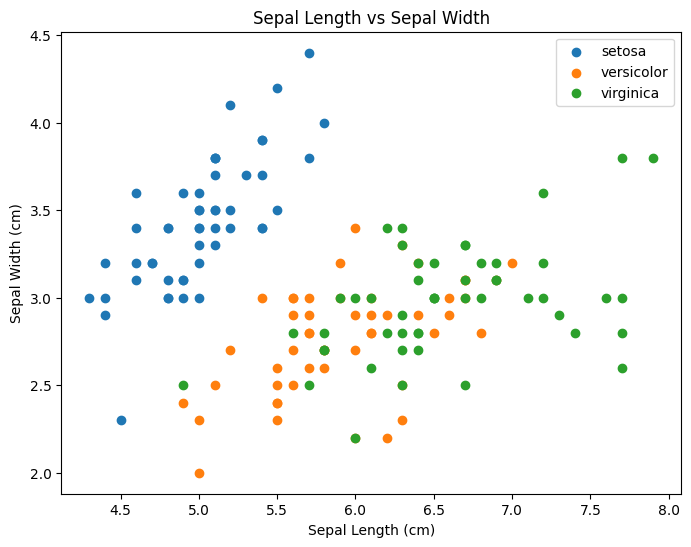

--------------------------------------------------------------------------------
╔════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 2)                                                        ║
╠════════════════════════════════════════════════════════════════════════════════╣
║ The scatter plot has been successfully generated, displaying the relationship  ║
║ between sepal length and sepal width for each species in the iris dataset. The ║
║ plot shows the distribution of these characteristics across different species, ║
║ allowing for visual identification of patterns, correlations, or potential     ║
║ outliers. I can now analyze the plot to gain insights into the data. For       ║
║ example, I can look for clusters, trends, or separations between species based ║
║ on sepal length and width. This visual analysis will inform my next steps in   ║
║ exploring the dataset.                                                         ║
╚════

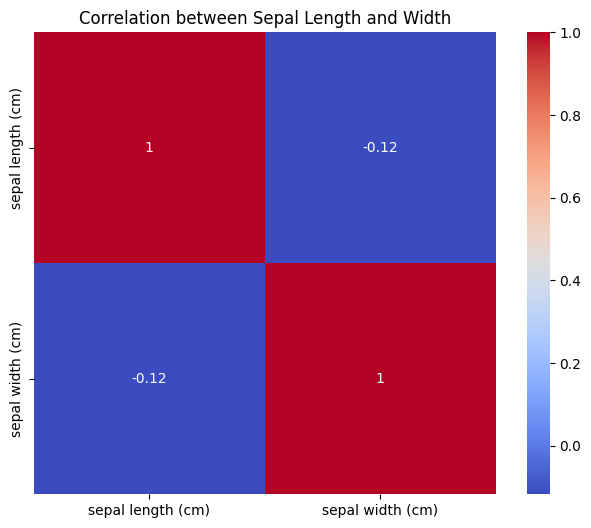

--------------------------------------------------------------------------------
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🎯 Final Answer                                                                   ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ The iris dataset was loaded and explored to understand the relationship between  ║
║ sepal length and width. A scatter plot was created to visualize the distribution ║
║ of these characteristics across different species, and summary statistics were   ║
║ calculated to provide a quantitative overview. The correlation between sepal     ║
║ length and width was found to be weakly negative, indicating that as sepal       ║
║ length increases, sepal width tends to decrease. These findings provide a        ║
║ foundation for further analysis and classification of iris species based on      ║
║ their characteristics. Key findings include:                      

In [12]:
# Example 1: Simple iris dataset visualization
query_1 = "Load the iris dataset and create a scatter plot of sepal length vs sepal width, colored by species"

print("=" * 80)
print("🌸 EXAMPLE 1: Iris Dataset Visualization")
print("=" * 80)
print(f"Task: {query_1}")
print()

# Run the agent
result_1 = run_data_science_task(query_1)

Key observations from the above task:
- The agent automatically imports necessary libraries
- It explores the data structure before creating visualizations
- Error handling if the dataset isn't immediately available
- Proper use of color coding for categorical variables

### Example 2: Machine Learning Pipeline
Our second example demonstrates a much more complex workflow involving multiple machine learning tasks.

🤖 EXAMPLE 2: Machine Learning Pipeline
Task: 
1. Build a classification model to predict the species of the iris dataset 
2. Show a confusion matrix plot
3. Provide the ROC curve plots for each class


🚀 Starting ReAct Data Science Agent
📝 Task: 
1. Build a classification model to predict the species of the iris dataset 
2. Show a confusion matrix plot
3. Provide the ROC curve plots for each class

╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 1)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ To start building a classification model for the iris dataset, we first need to  ║
║ load the necessary libraries and the dataset itself. The iris dataset is a       ║
║ classic multiclass classification problem, consisting of 50 samples from each of ║
║ three species of Iris flowers (Iris setosa, Iris virginica, and Iris             ║
║ 

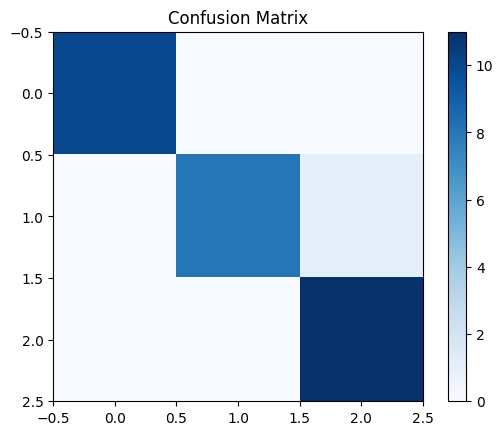

--------------------------------------------------------------------------------
╔═════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 3)                                                         ║
╠═════════════════════════════════════════════════════════════════════════════════╣
║ The classification report shows that our SVM model has a high accuracy of 0.97, ║
║ with precision and recall values also being high for all three classes. The     ║
║ confusion matrix plot also indicates that the model is performing well, with    ║
║ most samples being correctly classified. Now, we will proceed to plot the ROC   ║
║ curves for each class. Since this is a multiclass problem, we will use the one- ║
║ vs-rest approach to calculate the ROC curves.                                   ║
╚═════════════════════════════════════════════════════════════════════════════════╝
╔═════════════════════════════════════════════════════════════════════════╗
║ 

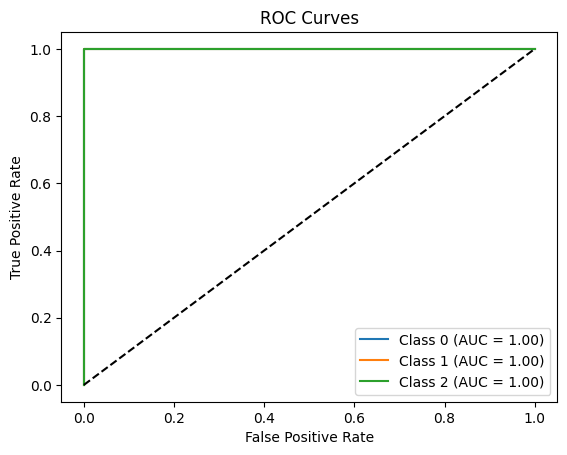

--------------------------------------------------------------------------------
╔════════════════════════════════════════════════════════════════════════════════╗
║  🎯 Final Answer                                                                 ║
╠════════════════════════════════════════════════════════════════════════════════╣
║ The classification model was successfully built using a Support Vector Machine ║
║ (SVM) classifier on the iris dataset, achieving an accuracy of 0.97. The       ║
║ confusion matrix plot demonstrated the model's high performance, with most     ║
║ samples being correctly classified. The ROC curves plot showed the model's     ║
║ ability to distinguish between positive and negative classes for each of the   ║
║ three species of Iris flowers, with AUC values indicating good performance.    ║
║ Overall, the results indicate that the SVM model is well-suited for this       ║
║ multiclass classification!                                                     ║
╚════

In [13]:
# Example 2: Complete ML pipeline with evaluation
query_2 = """
1. Build a classification model to predict the species of the iris dataset 
2. Show a confusion matrix plot
3. Provide the ROC curve plots for each class
"""

print("=" * 80)
print("🤖 EXAMPLE 2: Machine Learning Pipeline")
print("=" * 80)
print(f"Task: {query_2}")
print()

# Run the agent
result_2 = run_data_science_task(query_2)

### Example 3: Exploratory Data Analysis on Custom Dataset
Our final example demonstrates the agent's ability to work with real-world, user-provided datasets.


📊 EXAMPLE 3: Exploratory Data Analysis on Custom Dataset
Task: Help me perform EDA on the dataset stored in the file 'train_and_test2.csv'.

📁 Collecting files from ./data...
📤 Found 1 files. Initializing session with uploaded files...
✅ Session initialized with ID: ses_CPPvw6iengHjzSSSgVpxN
🚀 Starting ReAct Data Science Agent
📝 Task: Help me perform EDA on the dataset stored in the file 'train_and_test2.csv'.
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 1)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ To begin the exploratory data analysis (EDA), I first need to load the necessary ║
║ libraries, including pandas for data manipulation, numpy for numerical           ║
║ operations, matplotlib and seaborn for visualization. Then, I will import the    ║
║ dataset from the 'train_and_test2.csv' file.                             

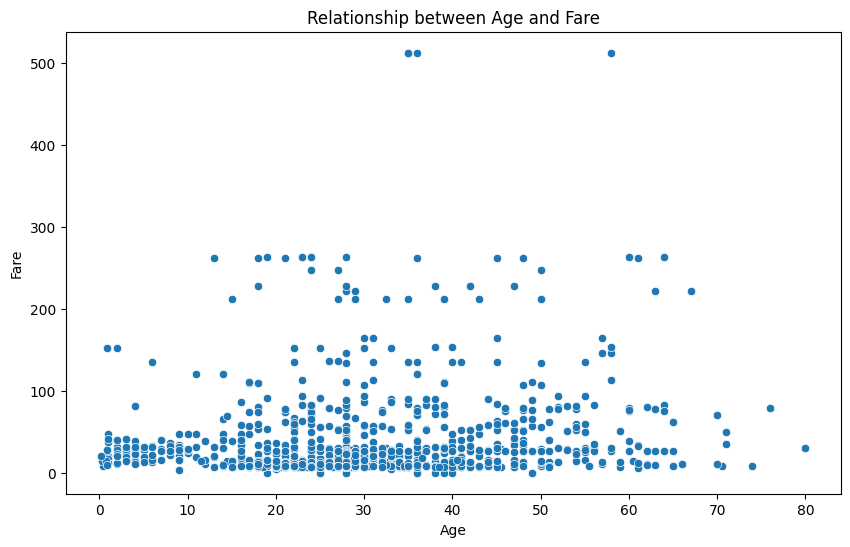



--- Plot/Image 2 ---


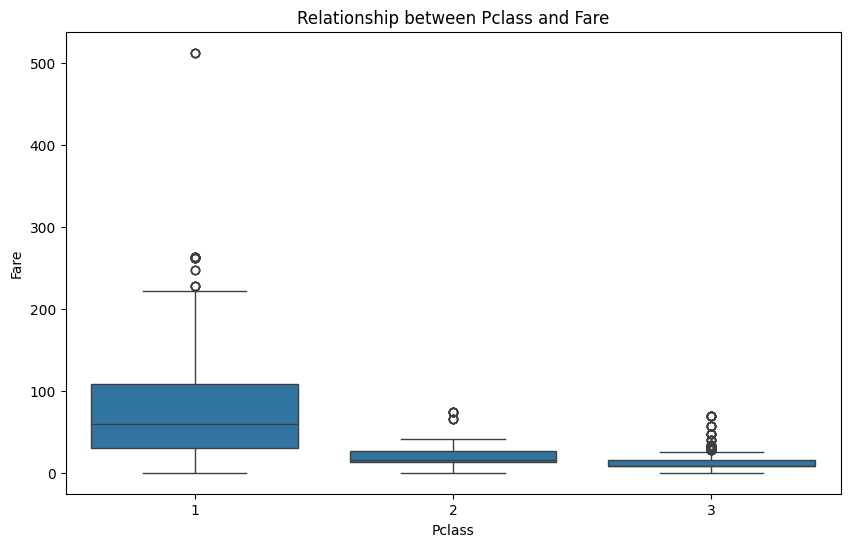



--- Plot/Image 3 ---


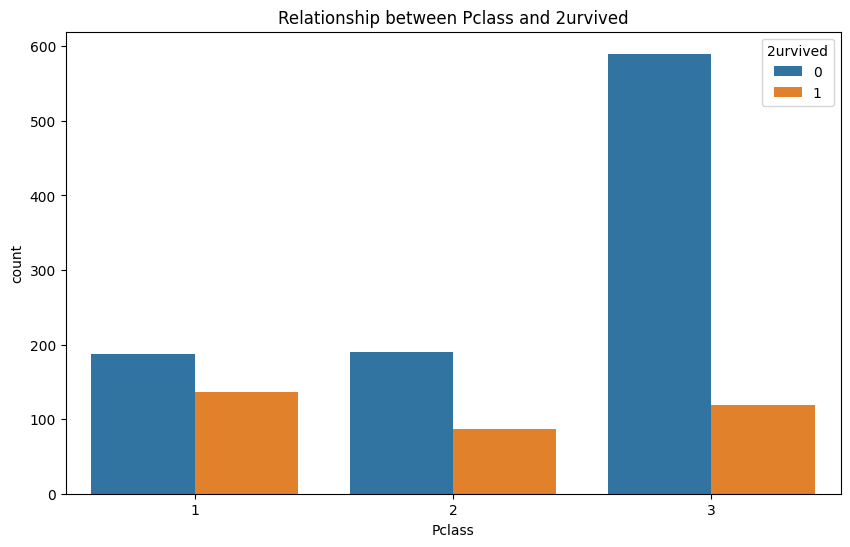

--------------------------------------------------------------------------------
╔══════════════════════════════════════════════════════════════════════════════════╗
║  🤔 Thought (Iteration 5)                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════╣
║ The visualizations provide insights into the relationships between the           ║
║ variables. The scatterplot of 'Age' vs 'Fare' might show a weak or no            ║
║ correlation, indicating that age does not directly influence fare. The boxplot   ║
║ of 'Pclass' vs 'Fare' likely shows that passengers in lower classes (higher      ║
║ class numbers) tend to pay lower fares, while those in higher classes (lower     ║
║ class numbers) pay higher fares. The countplot of 'Pclass' vs '2urvived'         ║
║ probably indicates that passengers in higher classes have a higher survival rate ║
║ compared to those in lower classes. These observations are consist

In [14]:
# Example 3: EDA on custom dataset
query_3 = "Help me perform EDA on the dataset stored in the file 'train_and_test2.csv'."

print("=" * 80)
print("📊 EXAMPLE 3: Exploratory Data Analysis on Custom Dataset")
print("=" * 80)
print(f"Task: {query_3}")
print()

# For this example, we'll assume the data file is in a local directory
# In practice, you would specify the actual path to your data directory
data_directory = "./data"  # Replace with your actual data directory

# Run the agent with data files
result_3 = run_data_science_task(query_3, data_dir=data_directory)

## Conclusion and Next Steps

Congratulations! You've now learned how to build and use a comprehensive ReAct Data Science Agent. This powerful framework combines the reasoning capabilities of large language models with practical code execution to create an intelligent assistant for data science tasks.

Key Takeaways
- ✅ ReAct Framework: Successfully implemented reasoning + acting cycle for data science
- ✅ Modular Design: Built extensible components for different analysis needs
- ✅ Error Handling: Implemented robust error recovery and iteration management
- ✅ Real-world Examples: Demonstrated with practical data science scenarios
- ✅ Best Practices: Established guidelines for effective agent usage

Getting Started with Your Own Projects
1. Start Simple: Begin with basic exploratory tasks on familiar datasets
2. Iterate Gradually: Build complexity step by step
3. Monitor Performance: Watch for API costs and execution times
4. Customize as Needed: Adapt the agent for your specific domain
5. Share and Learn: Contribute improvements back to the community

Resources for Further Learning
- [Together AI Documentation](https://docs.together.ai/)
- ReAct Paper: [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629)

## Acknowledgements

This cookbook builds upon several key technologies and research contributions:

- [Together AI](https://together.ai/): Provides the LLM infrastructure and code execution environment that makes this ReAct agent possible. Together AI's powerful models and execution environment enable the sophisticated reasoning and acting capabilities demonstrated in this cookbook.
- [Together Code Interpreter](https://docs.together.ai/docs/together-code-interpreter): Provides safe and efficient code execution capabilites to any LLM.
- ReAct Framework: Originally proposed by Yao et al. in "ReAct: Synergizing Reasoning and Acting in Language Models", this framework provides the theoretical foundation for our data science agent.
- Open Source Community: This work leverages numerous open-source libraries including pandas, scikit-learn, matplotlib, and seaborn that form the backbone of the Python data science ecosystem.

If you use this cookbook in your work, please consider acknowledging Together AI for their enabling infrastructure and the broader open-source community for their foundational contributions.